<a href="https://colab.research.google.com/github/usshaa/BK_BIRLA_DL/blob/main/07_DL/AnimeFaces_DCGAN_CaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🎨 Case Study 3: Anime Face Generation with DCGAN (Anime Faces Dataset)

In this notebook, we will build a **Deep Convolutional GAN (DCGAN)** to generate **anime-style faces** using the **Anime Faces dataset from Kaggle**.  

We will follow these steps:
1. Load and preprocess the dataset.
2. Build the Generator and Discriminator models.
3. Train the DCGAN.
4. Visualize generated anime faces.


In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator



## Step 1: Load and Preprocess Dataset

The Anime Faces dataset contains tens of thousands of cropped anime character faces.  

👉 Make sure you have downloaded the dataset from Kaggle and placed it in a local folder, e.g., `data/animefacedataset`.


In [3]:
!curl -L -o animefacedataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/splcher/animefacedataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  394M  100  394M    0     0   115M      0  0:00:03  0:00:03 --:--:--  133M


In [7]:
!unzip animefacedataset.zip -d animefacedataset

Streaming output truncated to the last 5000 lines.
  inflating: animefacedataset/images/62764_2019.jpg  
  inflating: animefacedataset/images/62765_2019.jpg  
  inflating: animefacedataset/images/62766_2019.jpg  
  inflating: animefacedataset/images/62767_2019.jpg  
  inflating: animefacedataset/images/62768_2019.jpg  
  inflating: animefacedataset/images/62769_2019.jpg  
  inflating: animefacedataset/images/6276_2003.jpg  
  inflating: animefacedataset/images/62770_2019.jpg  
  inflating: animefacedataset/images/62771_2019.jpg  
  inflating: animefacedataset/images/62772_2019.jpg  
  inflating: animefacedataset/images/62773_2019.jpg  
  inflating: animefacedataset/images/62774_2019.jpg  
  inflating: animefacedataset/images/62775_2019.jpg  
  inflating: animefacedataset/images/62776_2019.jpg  
  inflating: animefacedataset/images/62777_2019.jpg  
  inflating: animefacedataset/images/62778_2019.jpg  
  inflating: animefacedataset/images/62779_2019.jpg  
  inflating: animefacedataset/im

In [11]:
# Path to dataset (update if needed)
data_dir = "animefacedataset"

# Image generator for preprocessing
datagen = ImageDataGenerator(rescale=1./127.5 - 1)
img_size = 64
batch_size = 128

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode=None
)

print("Number of training samples:", train_data.n)

Found 63565 images belonging to 1 classes.
Number of training samples: 63565



## Step 2: Build the Generator

The Generator uses transposed convolutions to turn random noise vectors into **64x64 anime faces**.


In [12]:

def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 512)))

    model.add(layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5,5), strides=(1,1), padding='same', use_bias=False, activation='tanh'))
    return model

generator = build_generator()
generator.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     3,276,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 3)      │         4,800 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,715,264 (29.43 MB)

 Trainable params: 7,648,832 (29.18 MB)

 Non-trainable params: 66,432 (259.50 KB)


## Step 3: Build the Discriminator

The Discriminator is a CNN that distinguishes between real anime faces and generated ones.


In [13]:

def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[64,64,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator()
discriminator.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,045,633 (3.99 MB)

 Trainable params: 1,045,633 (3.99 MB)

 Non-trainable params: 0 (0.00 B)


## Step 4: Compile Models

We compile the Discriminator as a binary classifier, then link it with the Generator to form the DCGAN.


In [14]:

# Compile Discriminator
discriminator.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(0.0002, 0.5),
                      metrics=['accuracy'])

# Build DCGAN
discriminator.trainable = False
z = layers.Input(shape=(100,))
img = generator(z)
validity = discriminator(img)
dcgan = tf.keras.Model(z, validity)

dcgan.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))



## Step 5: Training the DCGAN

We train the GAN step by step and generate anime faces during training.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 9.3259, acc.: 35.94%] [G loss: 0.6806]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step


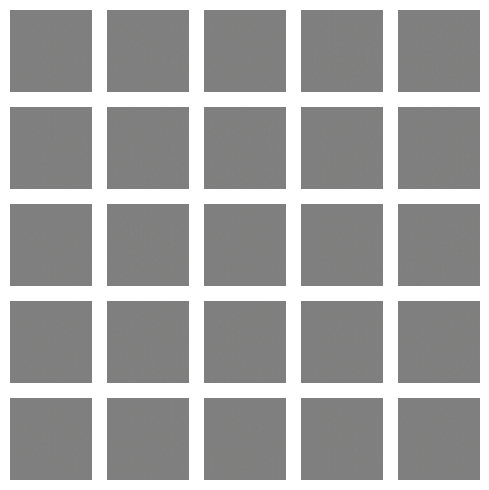

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━

In [ ]:

def train(epochs, batch_size=128, save_interval=1000):
    half_batch = int(batch_size / 2)

    for epoch in range(epochs):
        # ---------------------
        # Train Discriminator
        # ---------------------
        imgs = next(train_data)
        idx = np.random.randint(0, imgs.shape[0], half_batch)
        real_imgs = imgs[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        # Train Generator
        # ---------------------
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = dcgan.train_on_batch(noise, valid_y)

        # Print progress
        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

        # Save generated samples
        if epoch % save_interval == 0:
            save_images(epoch)

def save_images(epoch, examples=25, dim=(5,5), figsize=(5,5)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Train DCGAN (quick test; increase epochs for better results)
train(epochs=5000, batch_size=64, save_interval=1000)


# Save Trained Models

In [ ]:
# Save Generator and Discriminator
generator.save("anime_generator.h5")
discriminator.save("anime_discriminator.h5")

print("✅ Models saved successfully!")

### Loading the Models Later

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

# Load saved models
generator = load_model("anime_generator.h5")
discriminator = load_model("anime_discriminator.h5")

print("Models loaded successfully!")

# Test the Generator

In [ ]:
def generate_and_plot(generator, latent_dim=100, n_images=9):
    noise = np.random.normal(0, 1, (n_images, latent_dim))
    gen_images = generator.predict(noise)

    # Rescale images from [-1, 1] to [0, 1]
    gen_images = 0.5 * gen_images + 0.5

    plt.figure(figsize=(8,8))
    for i in range(n_images):
        plt.subplot(3, 3, i+1)
        plt.imshow(gen_images[i])
        plt.axis("off")
    plt.show()

In [ ]:
# Generate new anime faces
generate_and_plot(generator)


## ✅ Conclusion

We built and trained a **DCGAN to generate anime faces**.  
The Generator gradually learns to produce anime-style characters.  

- Increase the number of epochs (50,000+) for sharper faces.  
- You can try using **progressive growing GANs** for even better anime faces.  
